In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymongo
from pprint import pprint
import joblib

#### Prepare Ratings Data 

The ratings dataset contains approximately 27,000,000 ratings. This may require more processing power and memory than a personal computer is able to handle. We are first going to explore the data and then decide if we should split it based on a metric or just randomly select a percentage of the data. The decision will ultimately be made by testing different sizes on our chosen Machine Learning model.

In [5]:
ratings = pd.read_csv('Data/ratings.csv')

In [6]:
print(ratings.shape)
ratings.head()

(26024289, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [7]:
# no. of unique users

user_ct = ratings['userId'].unique()

print(len(user_ct))

# of unique movies

movie_ct = ratings['movieId'].unique()

print(len(movie_ct))

270896
45115


In [8]:
movies = pd.read_csv('Data/movies_final.csv')

movies.head()

,Unnamed: 0,movieId,genres,Title,year,Genre,Actors,Director,Plot,Poster
0,0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,"Animation, Adventure, Comedy, Family, Fantasy","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,A cowboy doll is profoundly threatened and jea...,https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,1,2,Adventure|Children|Fantasy,Jumanji,1995,"Adventure, Comedy, Family, Fantasy","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,When two kids find and play a magical board ga...,https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,2,3,Comedy|Romance,Grumpier Old Men,1995,"Comedy, Romance","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,John and Max resolve to save their beloved bai...,https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,3,4,Comedy|Drama|Romance,Waiting to Exhale,1995,"Comedy, Drama, Romance","Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Based on Terry McMillan's novel, this film fol...",https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,4,5,Comedy,Father of the Bride Part II,1995,"Comedy, Family, Romance","Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,George Banks must deal not only with the pregn...,https://m.media-amazon.com/images/M/MV5BOTEyNz...


In [9]:
movies.columns


Index(['Unnamed: 0', 'movieId', 'genres', 'Title', 'year', 'Genre', 'Actors',
       'Director', 'Plot', 'Poster'],
      dtype='object')

In [10]:
movies.drop(['Unnamed: 0'], axis=1, inplace = True)

In [11]:
# combine ratings and movies. only keep ratings where the movie exists in our dataset

movie_w_ratings = pd.merge(ratings, movies,how = 'inner', on='movieId')

In [12]:
print(movie_w_ratings.shape)
movie_w_ratings.head()

(15178941, 12)


,userId,movieId,rating,timestamp,genres,Title,year,Genre,Actors,Director,Plot,Poster
0,1,110,1.0,1425941529,Action|Drama|War,Braveheart,1995,"Biography, Drama, History, War","James Robinson, Sean Lawlor, Sandy Nelson, Jam...",Mel Gibson,When his secret bride is executed for assaulti...,https://m.media-amazon.com/images/M/MV5BMzkzMm...
1,11,110,3.5,1231676989,Action|Drama|War,Braveheart,1995,"Biography, Drama, History, War","James Robinson, Sean Lawlor, Sandy Nelson, Jam...",Mel Gibson,When his secret bride is executed for assaulti...,https://m.media-amazon.com/images/M/MV5BMzkzMm...
2,22,110,5.0,1111937009,Action|Drama|War,Braveheart,1995,"Biography, Drama, History, War","James Robinson, Sean Lawlor, Sandy Nelson, Jam...",Mel Gibson,When his secret bride is executed for assaulti...,https://m.media-amazon.com/images/M/MV5BMzkzMm...
3,24,110,5.0,979870012,Action|Drama|War,Braveheart,1995,"Biography, Drama, History, War","James Robinson, Sean Lawlor, Sandy Nelson, Jam...",Mel Gibson,When his secret bride is executed for assaulti...,https://m.media-amazon.com/images/M/MV5BMzkzMm...
4,29,110,3.0,1044020005,Action|Drama|War,Braveheart,1995,"Biography, Drama, History, War","James Robinson, Sean Lawlor, Sandy Nelson, Jam...",Mel Gibson,When his secret bride is executed for assaulti...,https://m.media-amazon.com/images/M/MV5BMzkzMm...


In [13]:
# find the number of unique users and unique movies

user_count = movie_w_ratings['userId'].unique()

print(len(user_count))

movie_count = movie_w_ratings['movieId'].unique()

print(len(movie_count))

267150
22203


The number of unique movies decreased from 45,115 to 22,203. The number of unique users decreased from 270,896 to 267,150. Despite the big drop in the number of movies, we still have 15,178,941 ratings.

In [14]:
# make new dataframe with only movieId, title, rating

new_ratings = movie_w_ratings[['userId','movieId', 'Title', 'rating']]

new_ratings.head()

,userId,movieId,Title,rating
0,1,110,Braveheart,1.0
1,11,110,Braveheart,3.5
2,22,110,Braveheart,5.0
3,24,110,Braveheart,5.0
4,29,110,Braveheart,3.0


#### Exploratory Data Analysis

In [15]:
# Find the average rating per movie title and sort

avg_movie_rate  = new_ratings.groupby('Title')['rating'].mean().sort_values(ascending=False)  

avg_movie_rate.head()

Title
Range 15                     5.0
Top of the World             5.0
Slingshot Hip Hop            5.0
Il cielo è sempre più blu    5.0
Double Daddy                 5.0
Name: rating, dtype: float64

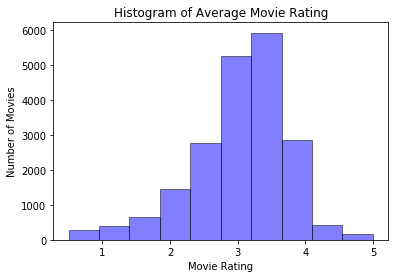

In [16]:
# create histogram to show avg movie rating

plt.hist(avg_movie_rate,
         bins=10,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Movie Rating')
plt.ylabel('Number of Movies')
plt.title('Histogram of Average Movie Rating')

plt.show()

In [17]:
# explore the number of ratings per movie

rate_counts = new_ratings.groupby('Title')['rating'].count().sort_values(ascending=False)

rate_counts.head(10)

Title
Forrest Gump                          91921
Pulp Fiction                          87901
Star Wars: Episode IV - A New Hope    77045
Jurassic Park                         74355
Schindler's List                      67662
Braveheart                            66512
Toy Story                             66008
Terminator 2: Judgment Day            61836
Fight Club                            60024
American Beauty                       57879
Name: rating, dtype: int64

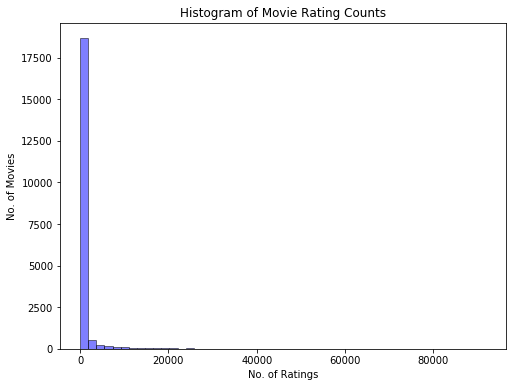

In [18]:
# create histogram to show number of ratings per movie

plt.figure(figsize=(8,6)) 
plt.hist(rate_counts,
         bins=50,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('No. of Ratings')
plt.ylabel('No. of Movies')
plt.title('Histogram of Movie Rating Counts')
# plt.xticks([0, 5000, 10000, 15000, 20000])

plt.show()

In [19]:
# create a dataframe to store the average ratings
ratings_mean_count = pd.DataFrame(new_ratings.groupby('Title')['rating'].mean())  

ratings_mean_count.head()

,rating
Title,
$5 a Day,2.971698
$50K and a Call Girl: A Love Story,3.750000
$9.99,3.107143
$ellebrity,2.357143
'71,3.715953


In [20]:
# add ratings_ct 

ratings_mean_count['rating_counts'] = pd.DataFrame(new_ratings.groupby('Title')['rating'].count())  

In [21]:
ratings_mean_count.head()

,rating,rating_counts
Title,,
$5 a Day,2.971698,53
$50K and a Call Girl: A Love Story,3.750000,2
$9.99,3.107143,70
$ellebrity,2.357143,7
'71,3.715953,257


In [22]:
# rename rating column to mean_rating

ratings_mean_count = ratings_mean_count.rename(columns = {'rating': 'mean_rating'})

In [23]:
# merge with new_ratings to get movie_Id

ratings_summ = pd.merge(ratings_mean_count, new_ratings, how='inner', on = 'Title')
print(ratings_summ.shape)
ratings_summ.head()

(15178941, 6)


,Title,mean_rating,rating_counts,userId,movieId,rating
0,$5 a Day,2.971698,53,1217,80361,2.5
1,$5 a Day,2.971698,53,18368,80361,4.0
2,$5 a Day,2.971698,53,20366,80361,4.0
3,$5 a Day,2.971698,53,33701,80361,3.0
4,$5 a Day,2.971698,53,37166,80361,3.5


In [24]:
# get the descriptive statistics for the dataset
ratings_mean_count.describe()

,mean_rating,rating_counts
count,20164.000000,20164.000000
mean,3.037785,752.774301
std,0.731171,3473.208063
min,0.500000,1.000000
25%,2.666667,3.000000
50%,3.138868,12.000000
75%,3.500000,111.000000
max,5.000000,91921.000000


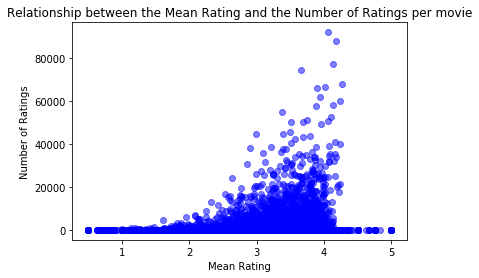

In [25]:
# create a scatter plot to explore the relationship between average rating and ratings count

x = ratings_mean_count['mean_rating']
y = ratings_mean_count['rating_counts']

plt.scatter(x, y, c='blue', alpha=0.5)
plt.title('Relationship between the Mean Rating and the Number of Ratings per movie')
plt.xlabel('Mean Rating')
plt.ylabel('Number of Ratings')
plt.show()

##### Explore User Behavior

In [26]:
# Find the number of ratings per User

ratings_per_user  = new_ratings.groupby('userId')['movieId'].count().sort_values(ascending=False)  

ratings_per_user.head()

userId
45811     8855
270123    4587
243443    4037
8659      3402
230417    3367
Name: movieId, dtype: int64

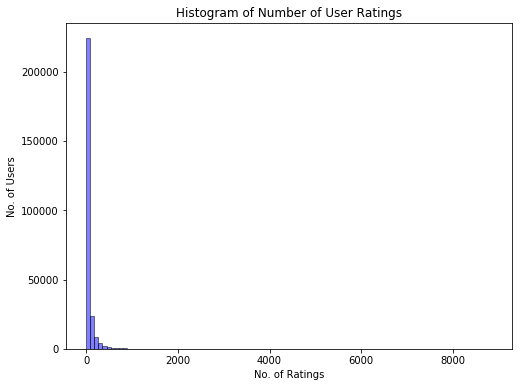

In [27]:
# Visualize User rating counts

plt.figure(figsize=(8,6)) 
plt.hist(ratings_per_user,
         bins=100,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('No. of Ratings')
plt.ylabel('No. of Users')
plt.title('Histogram of Number of User Ratings')
# plt.xlim([0,10000])

plt.show()

In [28]:
user_ratings = pd.DataFrame(new_ratings.groupby('userId')['movieId'].count().sort_values(ascending=False))

user_ratings = user_ratings.rename(columns = {'movieId': 'num_user_rated'})
user_ratings.head()

,num_user_rated
userId,
45811,8855
270123,4587
243443,4037
8659,3402
230417,3367


In [29]:
# get the descriptive statistics for the dataset
user_ratings.describe()

,num_user_rated
count,267150.000000
mean,56.818046
std,118.668410
min,1.000000
25%,8.000000
50%,18.000000
75%,56.000000
max,8855.000000


#### Recommendation System

In this section we will begin to explore different Machine Learning Models to decide which one best suits our data. We will look at K Nearest Neighbor (KNN), and Surprise SVD.

As mentioned above due to processing power we may have to reduce the amount of data. Our goal is to have a meaningful number of users and movies that can be processed on our desktop computers. We explored the following options.
1. We explored a hybrid of movie popularity and only using users that have rated between 50 and 150 movies. This resulted in too few movies (910) to have a quality dataset. 

2. We explored  According to our exploratory analysis, most users rate less than 200 movies. We then explored the data set using a variety of ranges to see what our desktop memory could accomodate. The sweet spot was between 75 and 150 ratings per user.

We chose option 2.It gave us 11102 movies rated by 27585 users.

In [30]:
# reduce size by eliminating movies rated less than 1000

pop_movies = ratings_summ.loc[ratings_summ['rating_counts'] > 5000]
print(pop_movies.shape)
pop_movies.head()

(10718845, 6)


,Title,mean_rating,rating_counts,userId,movieId,rating
3638,10 Things I Hate About You,3.515108,14793,12,2572,4.0
3639,10 Things I Hate About You,3.515108,14793,24,2572,3.0
3640,10 Things I Hate About You,3.515108,14793,29,2572,2.0
3641,10 Things I Hate About You,3.515108,14793,41,2572,5.0
3642,10 Things I Hate About You,3.515108,14793,43,2572,3.5


In [31]:
# reduce the size of the new_ratings dataframe. 
# filter the dataset to only include users who have rated > 50 but < than 150 movies

reg_users = user_ratings[(user_ratings['num_user_rated'] >= 75) & (user_ratings['num_user_rated'] <= 150)]
print(reg_users.shape)
reg_users.head()

(27585, 1)


,num_user_rated
userId,
33455,150
152343,150
169155,150
66713,150
97073,150


In [32]:
# Test join pop_movings and user count., The goal is to only include movies that have been rated > 10000
# times in the end

ratings_w_stats = pd.merge(pop_movies, reg_users, how = 'inner', on = 'userId')

print(ratings_w_stats.shape)
ratings_w_stats.head()

(2246911, 7)


,Title,mean_rating,rating_counts,userId,movieId,rating,num_user_rated
0,10 Things I Hate About You,3.515108,14793,12,2572,4.0,126
1,American Beauty,4.130704,57879,12,2858,5.0,126
2,Anaconda,2.083743,6914,12,1499,1.0,126
3,Antz,3.249202,12526,12,2294,2.0,126
4,Apollo 13,3.884031,57416,12,150,5.0,126


In [33]:
num_users = ratings_w_stats.userId.unique().shape[0]
num_movies = ratings_w_stats.movieId.unique().shape[0]
print (f"Number of users = {num_users} and Number of movies = {num_movies}")

Number of users = 27585 and Number of movies = 910


In [34]:
# join reg_users to new_ratings on userId. This will result in only the movies rated by our sub-group

ratings_sml = pd.merge(reg_users, new_ratings, how = 'inner', on = 'userId')

print(ratings_sml.shape)
ratings_sml.head()

(2892878, 5)


,userId,num_user_rated,movieId,Title,rating
0,33455,150,110,Braveheart,5.0
1,33455,150,2959,Fight Club,4.5
2,33455,150,4226,Memento,4.5
3,33455,150,4878,Donnie Darko,4.5
4,33455,150,5577,Igby Goes Down,4.0


In [36]:
#export ratings_sml

# ratings_sml.to_csv('Data/ratings_sml.csv', index=False)

In [51]:
# ratings_sml.to_hdf('Data/ratings_hdf.h5', key='ratings_sml',complib='blosc',complevel=9, mode='w' )

In [35]:
n_users = ratings_sml.userId.unique().shape[0]
n_movies = ratings_sml.movieId.unique().shape[0]
print (f"Number of users = {n_users} and Number of movies = {n_movies}")

Number of users = 27585 and Number of movies = 11102


In [36]:
# To ensure that our content system is pulling from the same group of movies,
# we are going to filter our movies dataframe to only display movies rated in ratings sml.

movies_sml = pd.merge(movies, ratings_sml, how = 'inner', on = 'movieId')

movies_sml.columns

Index(['movieId', 'genres', 'Title_x', 'year', 'Genre', 'Actors', 'Director',
       'Plot', 'Poster', 'userId', 'num_user_rated', 'Title_y', 'rating'],
      dtype='object')

In [37]:
# get only the unique movies

movies_sml = movies_sml[['movieId','Title_x','genres','Actors', 'Director', 'Plot', 'Poster' ]]

movies_sml = movies_sml.rename(columns = {'Title_x': 'Title'})

# drop duplicates

movies_sml.drop_duplicates(subset ="movieId", 
                     keep = 'first', inplace = True) 

print(movies_sml.shape)



(11102, 7)


In [36]:
# export to csv

# movies_sml.to_csv('Data/movies_sml.csv', index=False)

###### SVD Model

In [38]:
# pivot ratings into movie features
ratings_matrix = ratings_sml.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [39]:
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,175991,175993,175995,175999,176001,176003,176007,176157,176211,176271
userId,,,,,,,,,,,,,,,,,,,,,
12,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,3.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
rating

In [44]:
#compress ratings matrix

ratings_matrix.to_hdf('Data/ratings_mx.h5', key='ratings_matrix',complib='blosc',complevel=9, mode='w' )

In [40]:
# normalize the data by each users mean and convert it from a dataframe to a numpy array.

R = ratings_matrix.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [41]:
# Compute the largest k singular values/vectors for a sparse matrix

from scipy.sparse.linalg import svds

U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [42]:
# convert sigma to a diagonal matrix

sigma = np.diag(sigma)

In [40]:
# pickle other variables

# joblib.dump(U, 'Data/U.pkl')
# joblib.dump(Vt, 'Data/Vt.pkl')
# joblib.dump(sigma, 'Data/sigma.pkl')

['Data/sigma.pkl']

In [67]:
# calculate the dot product of our vectors
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [46]:
# joblib.dump(all_user_predicted_ratings, 'Data/all_user_predicted_ratings.pkl')

['Data/all_user_predicted_ratings.pkl']

In [68]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,175991,175993,175995,175999,176001,176003,176007,176157,176211,176271
0,2.560615,0.031274,-0.651091,0.020620,-0.533642,0.264343,-0.504495,-0.057654,-0.134222,0.201482,...,0.001771,0.001789,0.001807,0.001807,0.001807,0.001824,0.001754,0.001644,0.002967,0.002237
1,0.441066,-0.297052,0.211197,-0.065219,0.153935,2.553422,0.270768,-0.053733,0.102689,0.535472,...,-0.001425,-0.001077,-0.000729,-0.000729,-0.000729,-0.000382,-0.001773,-0.000501,-0.003033,-0.002046
2,-0.352039,-0.094756,-0.192779,0.064510,-0.023931,0.064820,-0.130847,0.012888,-0.102441,-0.709030,...,0.007978,0.007942,0.007906,0.007906,0.007906,0.007870,0.008014,0.009173,0.005091,0.006427
3,1.296987,1.336419,-0.154512,-0.097812,-0.045746,3.126836,-0.138816,-0.105895,0.094546,1.727142,...,-0.000140,-0.000042,0.000056,0.000056,0.000056,0.000154,-0.000238,0.002996,0.000401,-0.000531
4,4.743518,0.725185,-0.024024,-0.112855,0.097943,0.340626,0.199099,-0.030649,-0.011594,1.098070,...,0.001233,0.001167,0.001102,0.001102,0.001102,0.001036,0.001298,-0.000037,0.001855,0.002679


In [69]:
#convert preds to float32

preds.astype(np.float32)

movieId,1,2,3,4,5,6,7,8,9,10,...,175991,175993,175995,175999,176001,176003,176007,176157,176211,176271
0,2.560615,0.031274,-0.651091,0.020620,-0.533642,0.264343,-0.504495,-0.057654,-0.134222,0.201482,...,0.001771,0.001789,0.001807,0.001807,0.001807,0.001824,0.001754,0.001644,0.002967,0.002237
1,0.441066,-0.297052,0.211197,-0.065219,0.153935,2.553422,0.270768,-0.053733,0.102689,0.535472,...,-0.001425,-0.001077,-0.000729,-0.000729,-0.000729,-0.000382,-0.001773,-0.000501,-0.003033,-0.002046
2,-0.352039,-0.094756,-0.192779,0.064510,-0.023931,0.064820,-0.130847,0.012888,-0.102441,-0.709030,...,0.007978,0.007942,0.007906,0.007906,0.007906,0.007870,0.008014,0.009173,0.005091,0.006427
3,1.296987,1.336419,-0.154512,-0.097812,-0.045746,3.126836,-0.138816,-0.105895,0.094546,1.727142,...,-0.000140,-0.000042,0.000056,0.000056,0.000056,0.000154,-0.000238,0.002996,0.000401,-0.000531
4,4.743518,0.725185,-0.024024,-0.112855,0.097943,0.340626,0.199099,-0.030649,-0.011594,1.098070,...,0.001233,0.001167,0.001102,0.001102,0.001102,0.001036,0.001298,-0.000037,0.001855,0.002679
5,4.482482,0.558341,-0.483547,-0.139850,-0.140491,1.128887,0.049999,-0.064453,-0.185639,-0.321273,...,-0.010652,-0.010601,-0.010551,-0.010551,-0.010551,-0.010500,-0.010702,-0.008607,-0.006707,-0.007917
6,-0.658561,-0.227599,0.042870,0.019718,-0.183857,-1.031442,0.065091,-0.012830,0.127919,0.111786,...,0.011207,0.011163,0.011119,0.011119,0.011119,0.011075,0.011251,0.010293,0.012547,0.011792
7,3.247261,0.629626,-0.169783,-0.001588,-0.107664,-0.638315,-0.123142,0.007263,-0.117375,0.404349,...,0.006660,0.006712,0.006763,0.006763,0.006763,0.006815,0.006608,0.006862,0.007393,0.006667
8,5.311468,-0.069073,0.351197,-0.081460,0.061459,1.237441,0.087406,-0.036837,0.108486,0.872316,...,-0.004180,-0.004165,-0.004150,-0.004150,-0.004150,-0.004135,-0.004195,-0.005560,-0.006100,-0.002661
9,4.669407,0.507963,0.087863,-0.156521,-0.411690,3.167745,0.122809,-0.127738,-0.065429,0.774177,...,-0.002203,-0.002287,-0.002372,-0.002372,-0.002372,-0.002456,-0.002119,-0.003550,-0.002831,-0.002056


In [70]:
preds[preds < 0] = 0

In [82]:
# preds.to_hdf('Data/predsfin_hdf.h5', key='preds',complib='blosc',complevel=9, mode='w')

In [71]:
id = ratings_matrix.index
preds2 = preds.copy()


In [72]:
id = ratings_matrix.index
preds2['id'] = id

In [73]:
preds2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,175993,175995,175999,176001,176003,176007,176157,176211,176271,id
0,2.560615,0.031274,0.000000,0.02062,0.000000,0.264343,0.000000,0.000000,0.000000,0.201482,...,0.001789,0.001807,0.001807,0.001807,0.001824,0.001754,0.001644,0.002967,0.002237,12
1,0.441066,0.000000,0.211197,0.00000,0.153935,2.553422,0.270768,0.000000,0.102689,0.535472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15
2,0.000000,0.000000,0.000000,0.06451,0.000000,0.064820,0.000000,0.012888,0.000000,0.000000,...,0.007942,0.007906,0.007906,0.007906,0.007870,0.008014,0.009173,0.005091,0.006427,16
3,1.296987,1.336419,0.000000,0.00000,0.000000,3.126836,0.000000,0.000000,0.094546,1.727142,...,0.000000,0.000056,0.000056,0.000056,0.000154,0.000000,0.002996,0.000401,0.000000,34
4,4.743518,0.725185,0.000000,0.00000,0.097943,0.340626,0.199099,0.000000,0.000000,1.098070,...,0.001167,0.001102,0.001102,0.001102,0.001036,0.001298,0.000000,0.001855,0.002679,37


In [127]:
preds2.to_hdf('Data/predsfin_hdf.h5', key='preds',complib='blosc',complevel=9, mode='w')

C:\Users\zkxav\Anaconda3\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)


In [126]:
sorted_user_predictions = preds2.iloc[user_row_number].sort_values(ascending=False)

sorted_user_predictions.head()


movieId
id      33455.000000
296         6.990368
356         6.114470
1089        5.833004
1704        5.482397
Name: 3335, dtype: float64

In [115]:
sorted_user_predictions = pd.DataFrame(sorted_user_predictions[1:]).reset_index()

sorted_user_predictions.head()

,movieId,3335
0,356,6.114470
1,1089,5.833004
2,1704,5.482397
3,110,5.478840
4,150,5.247221


In [116]:

sorted_user_predictions.dtypes

movieId      int64
3335       float64
dtype: object

In [122]:
def recommend_movies(predictions, userId, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = preds2.loc[preds2['id']== userId].index[0]
    
    sorted_user_predictions = preds2.iloc[user_row_number].sort_values(ascending=False) 
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions[1:]).reset_index()
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userId)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

#     print (f"User {0} has already rated {1} movies. format(userID, user_full.shape[0]")
#     print 'Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations)
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_sml[~movies_sml['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations]
                      )
    rec_movies = recommendations['Title']
    already_rated = user_full['Title_x']
    return  already_rated, rec_movies

In [123]:
already_rated, predictions = recommend_movies(preds, 33455, movies, ratings_sml, 10)

In [124]:
predictions

756            Stand by Me
2954          Finding Nemo
2026             Cast Away
1013         Boogie Nights
1334    American History X
1794         High Fidelity
4                     Heat
2015                Snatch
1048          Jackie Brown
86           Happy Gilmore
Name: Title, dtype: object

In [125]:
already_rated

0                        Braveheart
55        In the Name of the Father
63                      Sling Blade
61                         Swingers
60                    Trainspotting
59                            Fargo
57                     True Romance
56      Searching for Bobby Fischer
54      What's Eating Gilbert Grape
66                      Chasing Amy
53                 Dead Man Walking
50              Saving Private Ryan
49     There's Something About Mary
48                          Titanic
45                   Reservoir Dogs
44                     Forrest Gump
65                          Contact
67                Good Will Hunting
36                  Minority Report
112                       Footloose
139             Murder in the First
135                     Simon Birch
131               Road to Perdition
130                     About a Boy
124                        Sleepers
114     Four Weddings and a Funeral
108                         Traffic
76                     Offic

#### Store Prediction Results in MongoDB

